In [62]:
from os import chdir
from pathlib import Path
import scipy as sp
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set wd to repos main folder
chdir(Path(".."))

In [3]:
home_dir = Path.cwd()
result_dir = home_dir / "results"


In [4]:
score_files = [file for file in result_dir.rglob("*") if file.match("scores.txt")]

In [5]:
random_score_files = [file for file in score_files if file.parent.parent.match("random")]
experiment_score_files = [file for file in score_files if file.parent.parent.match("*advantage")]

In [6]:
random_scores = {"scores": []}
for file in random_score_files:
    with file.open() as f:
        for line in f:
            random_scores["scores"].append(line[:-1])

df_rand_scores = pd.DataFrame(random_scores).sample(n=320)

df_rand_scores = df_rand_scores.astype(dtype={"scores": "float"})

frames = {}
for score_file in experiment_score_files:
    frames[score_file.parent.parent.name] = \
        pd.read_table(filepath_or_buffer=score_file,
            header=0,
            index_col=False,
            encoding="utf-8"
        )

df_advantage_eval = frames["advantage"]
df_disadvantage_eval = frames["disadvantage"]

In [7]:
rand_eval = {
                "obs": [df_rand_scores.count()[0]],
                "mean": [df_rand_scores.mean(axis=0)[0]]
            }

df_rand_eval = pd.DataFrame(rand_eval)

In [8]:
experiments_ttest_t, experiments_ttest_p = scipy.stats.ttest_ind_from_stats(
    mean1=df_advantage_eval["mean"],
    std1=df_advantage_eval["stdev"],
    nobs1=df_advantage_eval.count()[0],
    mean2=df_disadvantage_eval["mean"],
    std2=df_disadvantage_eval["stdev"],
    nobs2=df_disadvantage_eval.count()[0]
)

df_experiments_tests = pd.DataFrame({"t-test_t-wert": experiments_ttest_t, "t-test_p-wert": experiments_ttest_p})

In [9]:
def calc_cohens_d(mean_1, mean_2, stdev_1, stdev_2):
    assert len(mean_1) == len(mean_2) == len(stdev_1) == len(stdev_2), \
    "parameters must be of the same length"
    assert not isinstance(mean_1, list) or not isinstance(mean_2, list) or \
    not isinstance(stdev_1, list) or not isinstance(stdev_2, list), \
    "paramers must be of type list"

    cohens_d = []
    for i in range(len(mean_1)):
        tmp = (mean_1[i] - mean_2[i]) / ((stdev_1[i]**2 + stdev_2[i]**2) / 2)**0.5
        cohens_d.append(tmp)
    return cohens_d

In [10]:
df_experiments_tests["cohens_d"] = calc_cohens_d(
    mean_1=df_advantage_eval["mean"],
    stdev_1=df_advantage_eval["stdev"],
    mean_2=df_disadvantage_eval["mean"],
    stdev_2=df_disadvantage_eval["stdev"],
)

In [71]:
df_experiments_tests.columns

Index(['t-test_t-wert', 't-test_p-wert', 'cohens_d'], dtype='object')

In [33]:
training_mean = {
    "advantage": df_advantage_eval['mean'],
    "disadvantage": df_disadvantage_eval['mean'],
    "random": np.full(320, df_rand_eval["mean"])
}

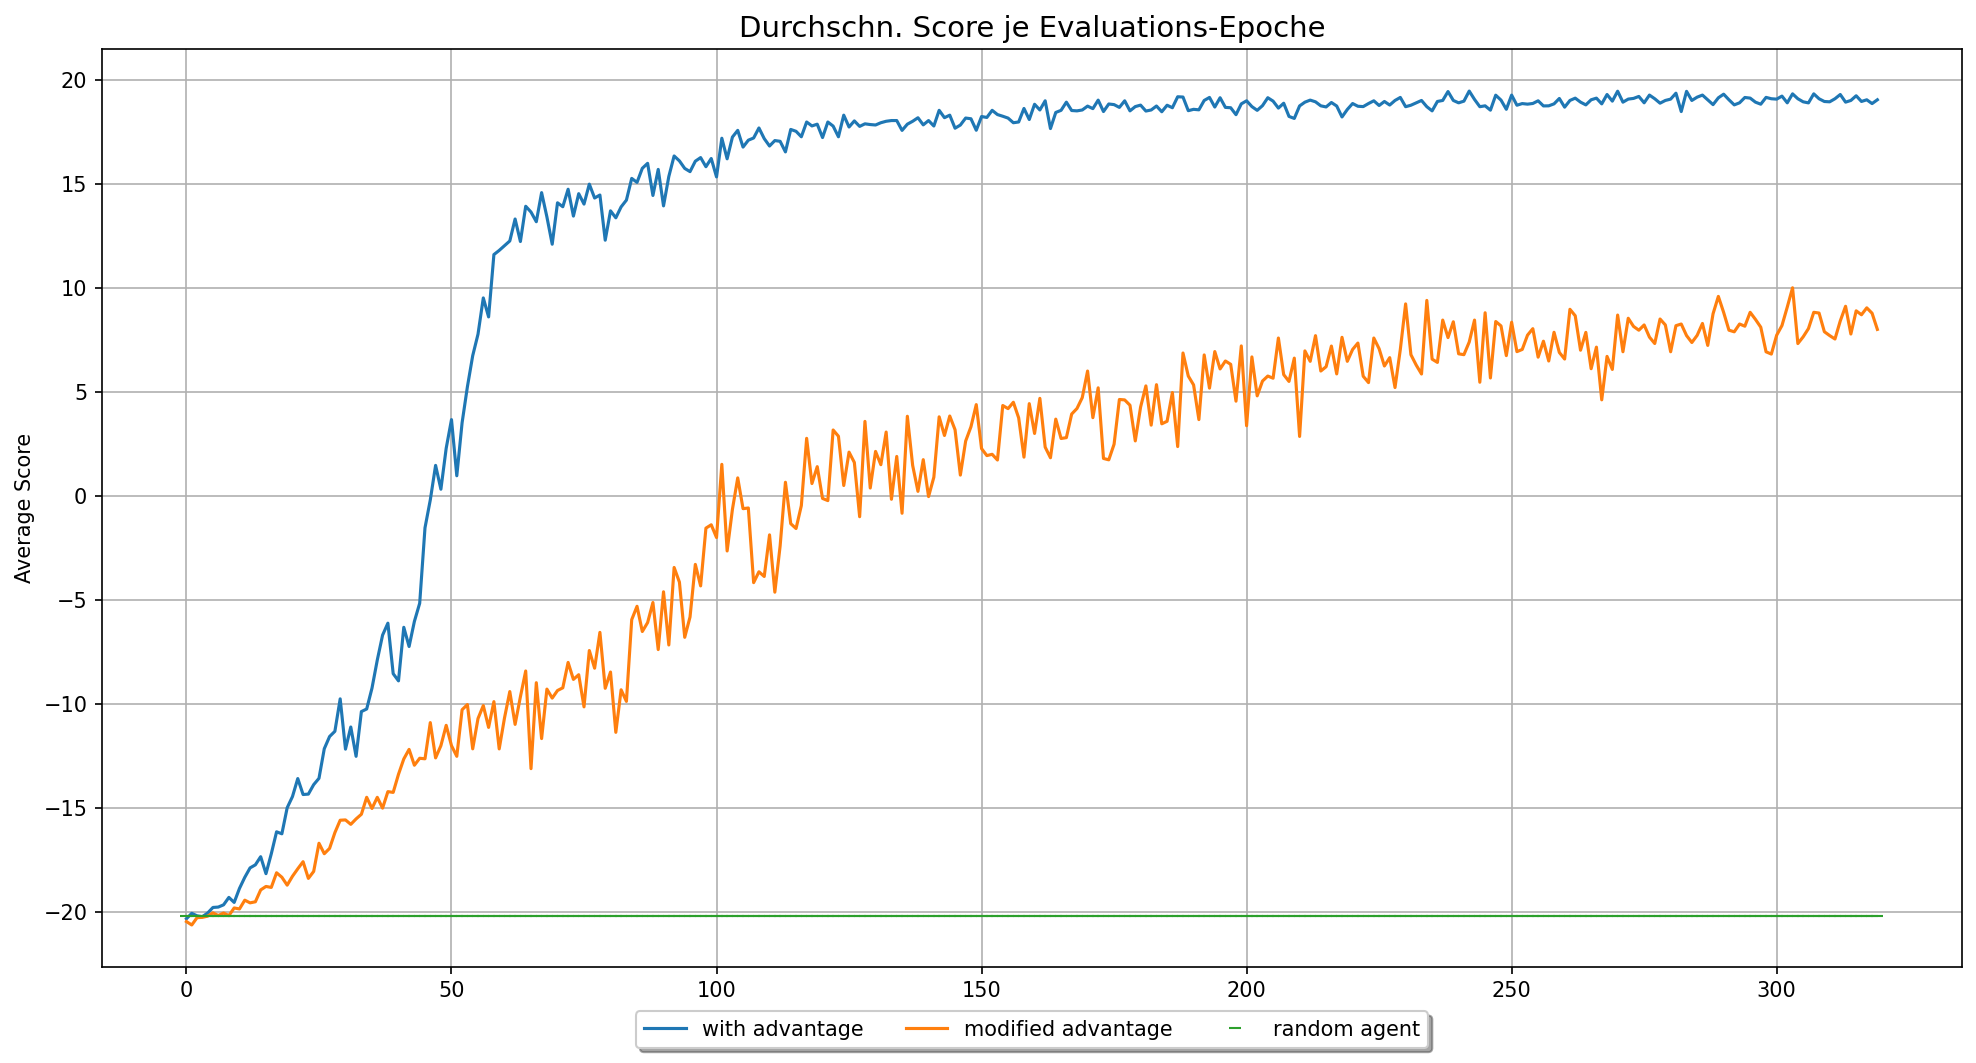

In [99]:
plt.figure(figsize=(16, 9), dpi=150)
plt.plot("advantage", "-", data=training_mean)
plt.plot("disadvantage", data=training_mean)
plt.plot("random", "_", data=training_mean)
plt.ylabel("Average Score")
plt.xlabel("Evaluation Epoch")
plt.title("Durchschn. Score je Evaluations-Epoche", fontdict={"fontsize": 14})
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height*0.9])
plt.legend(labels=["with advantage","modified advantage", "random agent"],
            loc='lower center',
            ncol=3,
            bbox_to_anchor=[0.5, -0.1],
            fancybox=True,
            shadow=True)
plt.grid(which="major",
            axis="both")
plt.savefig("avg_training_score.png")
plt.show()

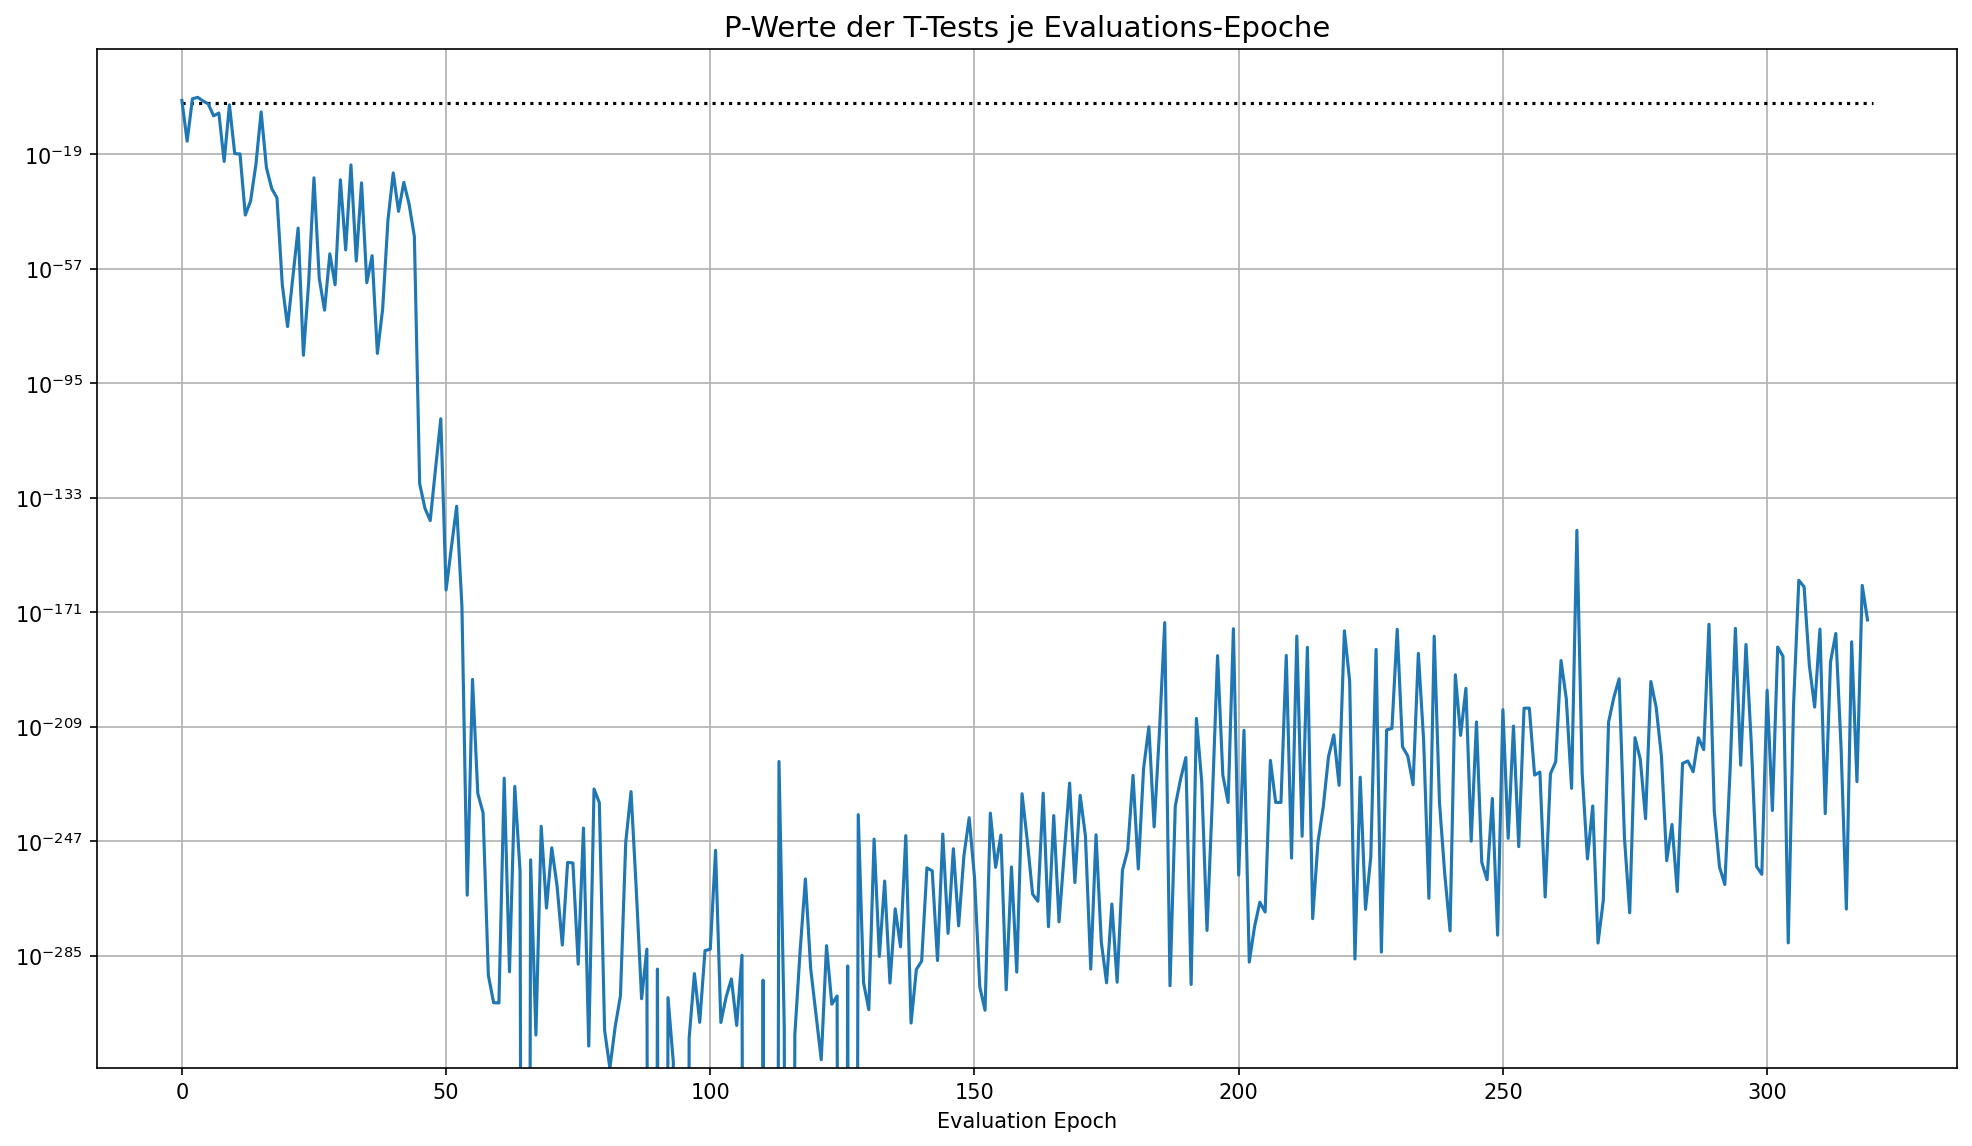

In [100]:
plt.figure(figsize=(16, 9), dpi=150)
plt.plot("t-test_p-wert", data=df_experiments_tests)
# plt.plot("t_test_t-wert", "_", data=df_experiments_tests)
plt.xlabel("Evaluation Epoch")
plt.title("P-Werte der T-Tests je Evaluations-Epoche",
    fontdict={"fontsize": 14})
plt.grid(which="major",
            axis="both")
plt.hlines(0.01, xmin=0, xmax=320, linestyles="dotted", label="strong effect")
plt.yscale(value="log")
plt.savefig("t-test.png")
plt.show()

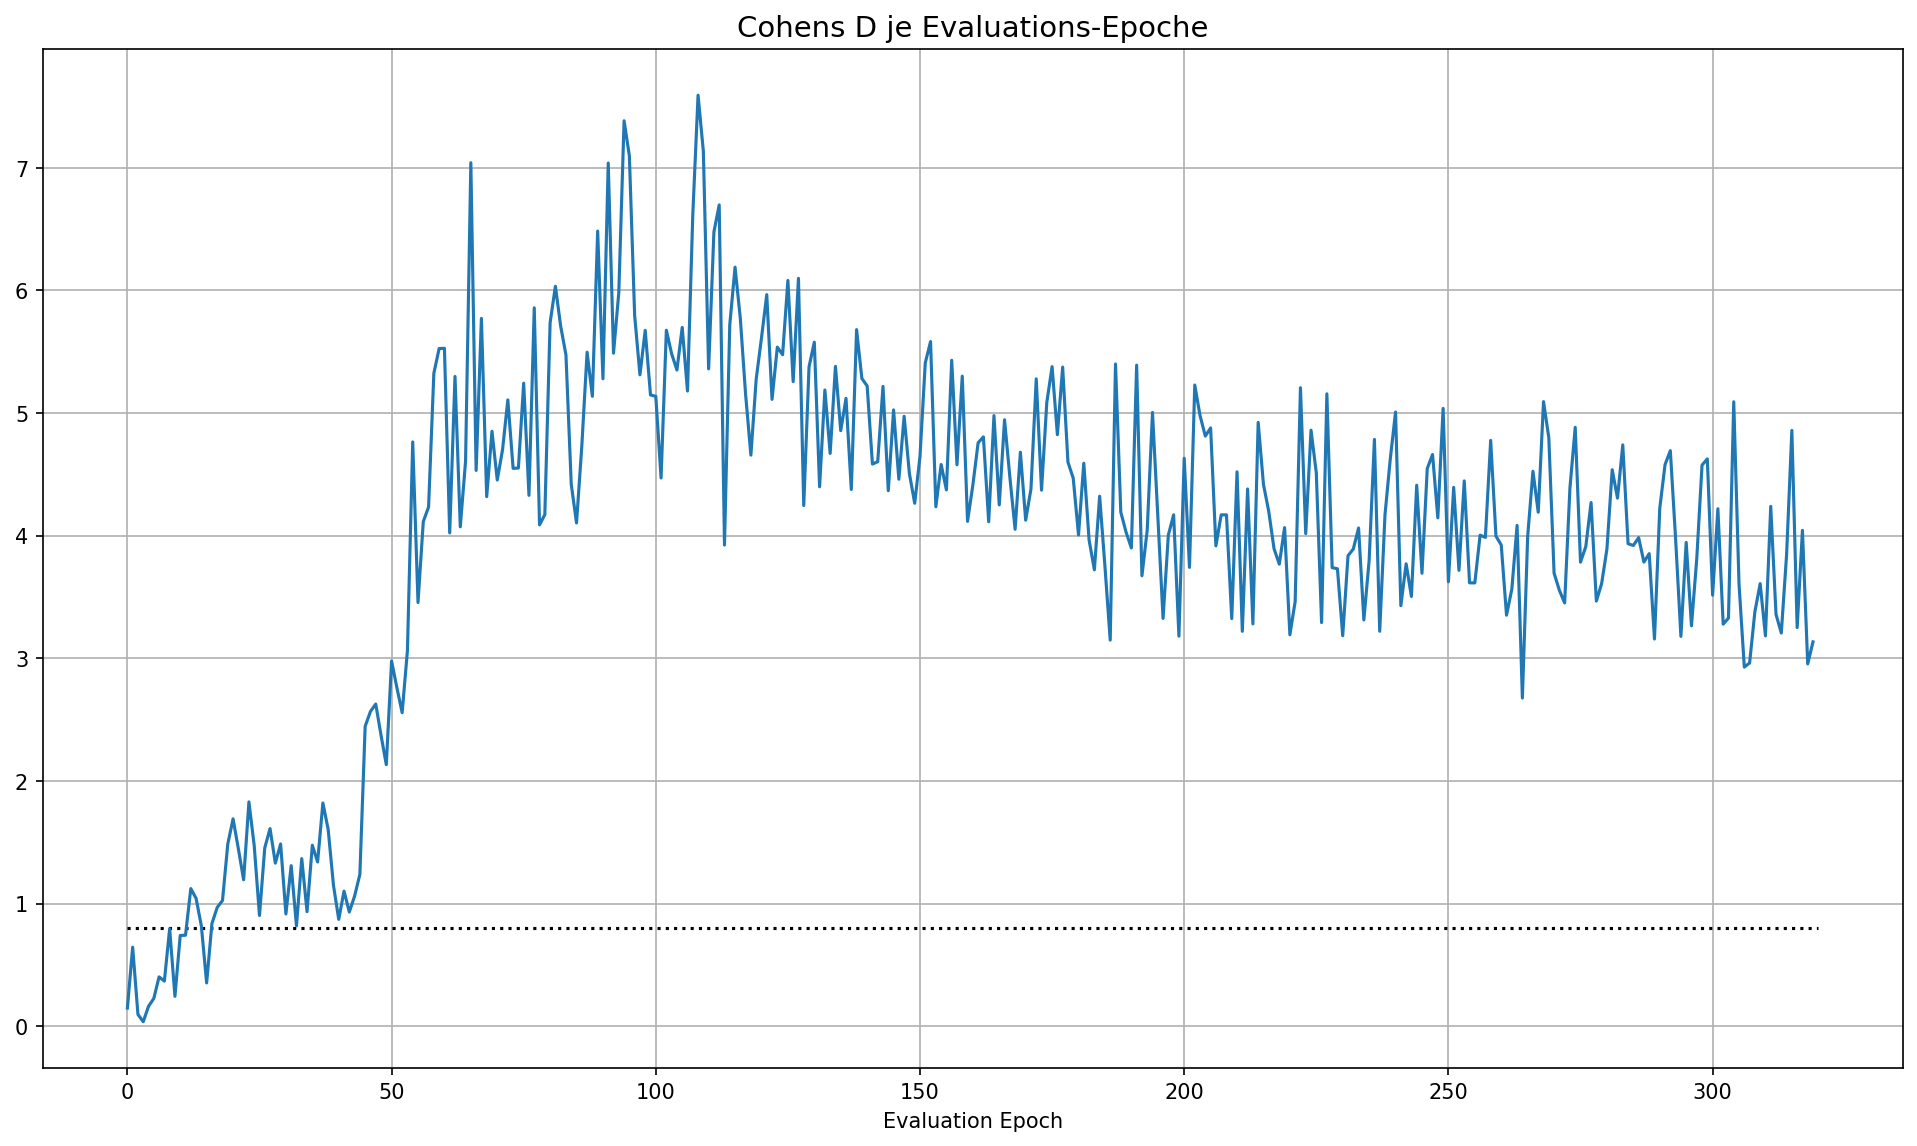

In [101]:
plt.figure(figsize=(16, 9), dpi=150)
plt.plot("cohens_d", "-", data=df_experiments_tests)
plt.xlabel("Evaluation Epoch")
plt.title("Cohens D je Evaluations-Epoche", fontdict={"fontsize": 14})
plt.grid(which="major",
            axis="both")
plt.hlines(0.8, xmin=0, xmax=320, linestyles="dotted", label="strong effect")
plt.savefig("cohens_d.png")
plt.show()